In [3]:
%matplotlib inline
import skimage.transform
import math
import matplotlib.pyplot as plt
import skimage.data

In [4]:
from mxnet import nd

C:\Users\v-dinliu\AppData\Local\Continuum\anaconda3\envs\mxnet\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [75]:
%%time
import sys
sys.path.append('//msralab/projectdata/ehealth02/v-dinliu/Flow2D')
from reader.chairs import binary_reader, trainval
trainSet, validationSet = trainval.read('//msralab/ProjectData/ehealth02/v-dinliu/Flow2D/Data/FlyingChairs_release/FlyingChairs_train_val.txt')
validationSize = len(validationSet)
validationImg1, validationImg2, validationFlow = binary_reader.load(r"\\msralab\ProjectData\ScratchSSD\Users\v-dinliu\data\FlyingChairsBlock", "val")

Wall time: 17.9 s


In [178]:
import augmentation
from importlib import reload
reload(augmentation)

<module 'augmentation' from '//msralab/projectdata/ehealth02/v-dinliu/Flow2D\\augmentation.py'>

In [179]:
aug = augmentation.GeometryAugmentation(angle_range=(-17, 17), zoom_range=(0.5, 1.11), translation_range=0.1, target_shape=(320, 448),
                                        orig_shape=(384, 512), batch_size=2)
aug.hybridize()

In [180]:
i=30
j=32
img1, img2, flow = map(lambda x : nd.array(x[i:j]).transpose([0, 3, 1, 2]), (validationImg1, validationImg2, validationFlow))

In [183]:
aimg1, aimg2, aflow = map(lambda x : x[0].transpose([1, 2, 0]).asnumpy(), aug(img1,img2,flow))

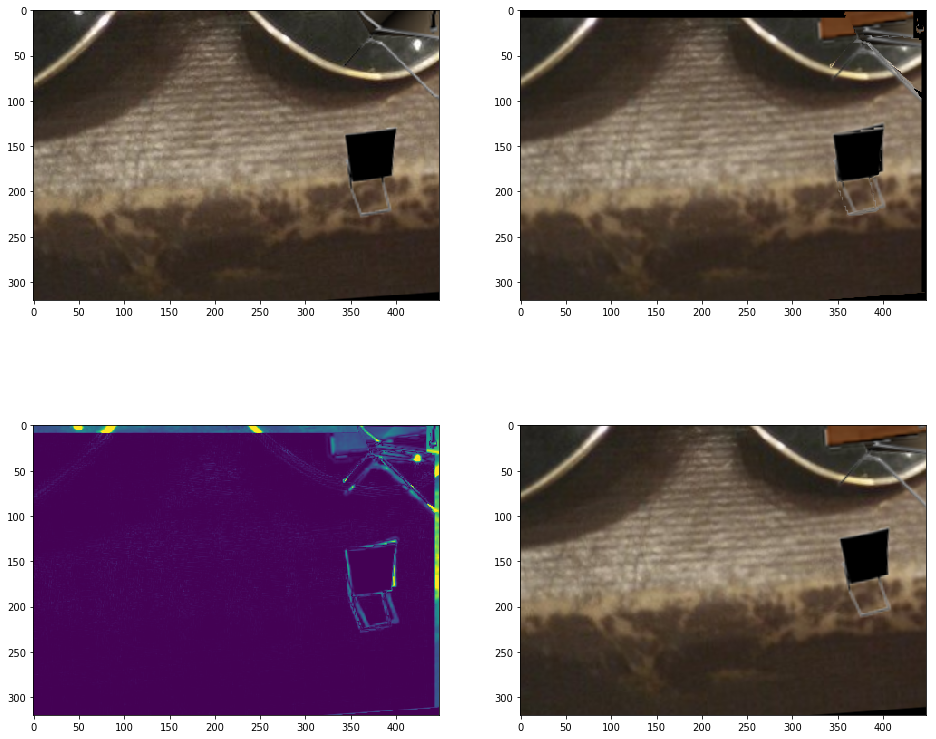

In [184]:
show_diff(aimg1, aimg2, aflow)

In [1]:
import numpy as np

In [30]:
def show_diff(img1, img2, flow):
    plt.figure(figsize=(16, 14))
    plt.subplot(221)
    plt.imshow(img1)
    grids = nd.GridGenerator(nd.array(np.transpose(flow, (2, 0, 1))[None] ), 'warp')
    warp = nd.BilinearSampler(nd.array(np.transpose(skimage.img_as_float(img2), (2, 0, 1))[None]), grids)
    plt.subplot(222)
    warped=np.transpose(warp.asnumpy()[0], (1, 2, 0))
    plt.imshow(warped)
    diff=skimage.img_as_float(img1) - warped
    plt.subplot(223)
    plt.imshow(np.linalg.norm(diff, axis=-1), vmax=1)
    diff=skimage.img_as_float(img1) - skimage.img_as_float(img2)
    plt.subplot(224)
    plt.imshow(img2)

In [67]:
transform = skimage.transform.AffineTransform(rotation=math.pi/10, scale=(0.9, 0.9))

In [94]:
def augmentation(img1, img2, flow):
    '''
    '''
    rows, cols = img1.shape[:2]
    center = cols / 2 - 0.5, rows / 2 - 0.5
    transform = skimage.transform.AffineTransform(rotation=math.pi/3, scale=(0.8, 0.8))
    translation = np.dot(np.identity(2) - transform.params[:2, :2], center)
    transform.params[:2, 2] = translation
    concat_img = np.concatenate([img1 / 255.0, img2 / 255.0, flow], axis=-1)
    concat_img = skimage.transform.warp(concat_img.astype(np.float64), transform)
    flow = concat_img[..., 6:8]
    rinv = np.linalg.inv(transform.params[:2, :2]).transpose()
    flow[:] = np.reshape(np.matmul(np.reshape(flow, [-1, 2]),rinv),flow.shape)
    return concat_img[..., :3], concat_img[..., 3:6], flow

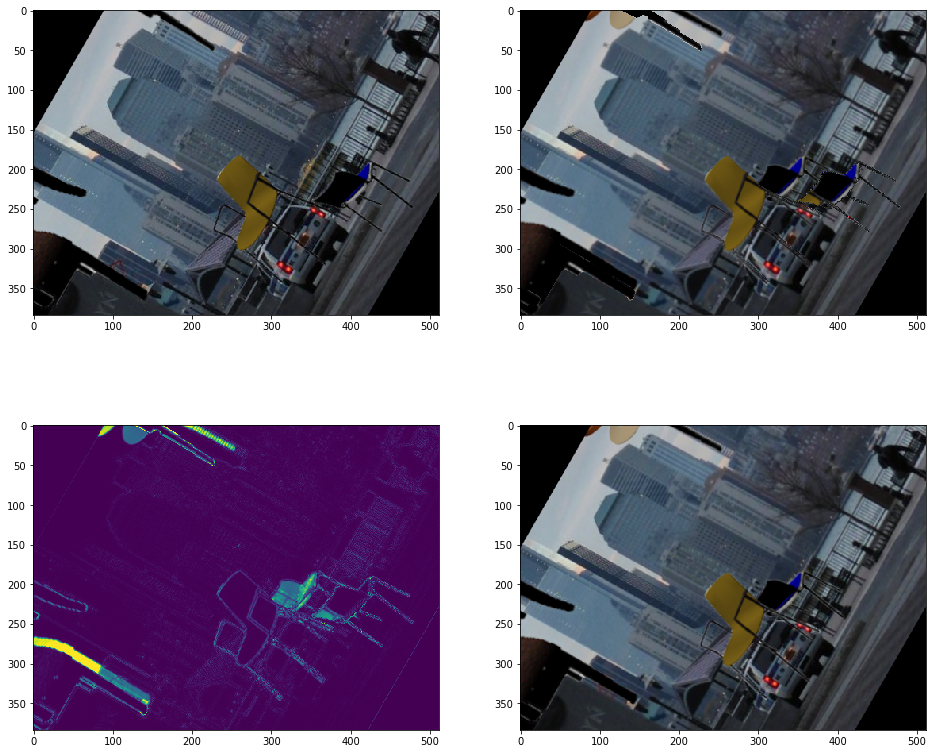

In [95]:
show_diff(*augmentation(img1, img2, flow))